In [5]:
!pip install ultralytics timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 8.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
from ultralytics import YOLO
import cv2
import math
import os
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

# Specify the directory where you want to save the frames
output_directory = "/content/output"

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the YOLO model
model = YOLO("/content/yolov8l.pt")

# Load the MiDaS model from PyTorch Hub
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").eval()

# Customized class names for campus navigation
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "com", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork",
              "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
              "pizza", "donut", "cake", "chain", "sofa", "potted-plant", "bed", "table", "toilet", "tv-monitor",
              "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
              "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair dryer", "toothbrush"]

# Function to calculate depth map using the MiDaS model
def calculate_depth_map(image):
    # Resize the input image to the required size
    transform = T.Compose([T.Resize(384), T.ToTensor()])
    input_image = transform(Image.fromarray(image)).unsqueeze(0)

    with torch.no_grad():
        prediction = midas(input_image)

    depth_map = prediction.squeeze().cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

    # Adjust the scaling factor based on the MiDaS model's output
    scaling_factor = 0.01
    depth_map = depth_map * scaling_factor

    return depth_map



# Function to calculate distance using the depth map
def calculate_distance(x1, y1, x2, y2, depth_map):
    # Calculate the center coordinates of the bounding box
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # Convert the center coordinates to integer
    center_x = int(center_x)
    center_y = int(center_y)

    # Get the depth value at the center coordinates from the depth map
    distance = depth_map[center_y, center_x]

    return distance

# Function to process an image and return detected objects, their distances, and the modified image
def process_image(image):
    depth_map = calculate_depth_map(image)

    results = model(image)

    detected_objects = {}
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1
            conf = math.ceil((box.conf[0] * 100)) / 100
            cls = int(box.cls[0])
            object_name = classNames[cls]

        # Calculate the distance using the depth map
        distance = calculate_distance(x1, y1, x2, y2, depth_map)

        detected_objects[object_name] = distance

        # Draw bounding boxes and labels on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green bounding box
        cv2.putText(image, f"{object_name} ({conf:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image, detected_objects

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


In [76]:
# Load your image file
ima = cv2.imread("/content/BLACK.png")

image = cv2.resize(ima, (384, 384))

In [46]:
!pip install utils

In [43]:
import utils
display = utils.notebook_init()

AttributeError: ignored

In [44]:
model.info()

YOLOv8l summary (fused): 268 layers, 43668288 parameters, 0 gradients, 165.2 GFLOPs


(268, 43668288, 0, 165.1567104)


0: 640x640 3 persons, 1 bench, 1 backpack, 4314.7ms
Speed: 13.2ms preprocess, 4314.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


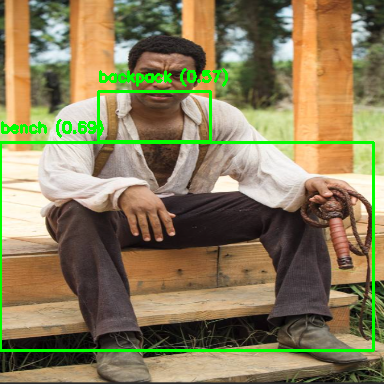

In [80]:
# Process the image and get detected objects, the modified image, and object distances
processed_image, detected_objects = process_image(image)


# Display the modified image
from google.colab.patches import cv2_imshow
cv2_imshow(processed_image)


In [82]:
detected_objects

{'backpack': 1.7269948}

In [81]:
# Display detected objects and their distances
for object_name, distance in detected_objects.items():
    print(f"Object: {object_name}, Distance: {distance} meters")

Object: backpack, Distance: 1.7269947528839111 meters
